In [33]:
# Gym stuff
import gymnasium as gym
import gym_anytrading
import torch

# Stable baselines - rl stuff
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import seaborn as sns

In [ ]:
df = pd.read_csv('../data/gmedata.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,03/12/2021,275.00,295.50,262.27,264.5,"25,845,900"
1,03/11/2021,241.64,281.50,232.60,260.0,"28,312,490"
2,03/10/2021,269.43,348.50,172.00,265.0,"71,570,570"
3,03/09/2021,217.71,249.85,208.51,246.9,"39,099,328"
4,03/08/2021,154.89,210.87,146.10,194.5,"63,565,621"


In [35]:
# Preprocessing

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-03-12,275.00,295.50,262.27,264.5,"25,845,900"
2021-03-11,241.64,281.50,232.60,260.0,"28,312,490"
2021-03-10,269.43,348.50,172.00,265.0,"71,570,570"
2021-03-09,217.71,249.85,208.51,246.9,"39,099,328"
2021-03-08,154.89,210.87,146.10,194.5,"63,565,621"


In [36]:
env = gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)
# It is to be noted that the first element of frame_bound should be greater than or equal to window_size.

In [37]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> Action space:", env.unwrapped.action_space)
print("> Observation space:", env.unwrapped.observation_space)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (5, 2)
> Action space: Discrete(2)
> Observation space: Box(-10000000000.0, 10000000000.0, (5, 2), float32)
> df.shape: (251, 5)
> prices.shape: (100,)
> signal_features.shape: (100, 2)
> max_possible_profit: 84.81693845797723


info: {'total_reward': 165.2800054550171, 'total_profit': 1.2660997120632607, 'position': <Positions.Long: 1>}


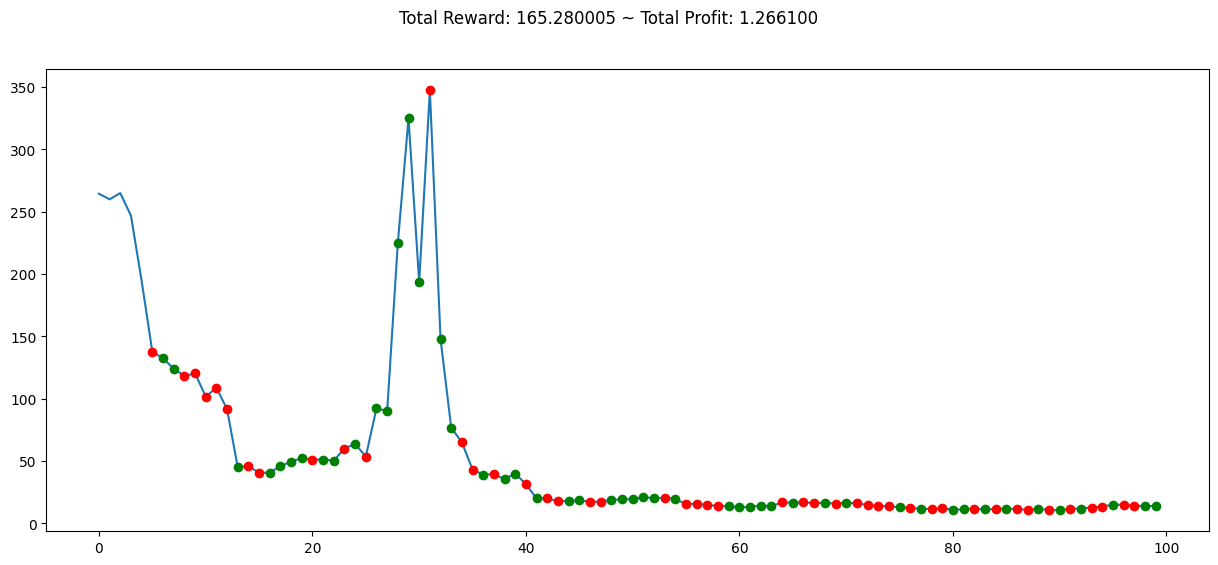

In [38]:
# Random action space
observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.unwrapped.render_all()
plt.show()

In [39]:
# Build and train environment in environment
env_name = 'stocks-v0'  # or 'forex-v0'
env = gym.make(env_name)

def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max

In [40]:
# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

In [41]:
# TRAINING + TESTING function
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """
    
    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback. 
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                break

        reward_over_episodes.append(total_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes

In [42]:
# Train + Test the environment

seed = 42  # random seed
total_num_episodes = 50

print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None 
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min, avg, max = print_stats(rewards)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}

learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [A2C, PPO]

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'

    for model_class in model_class_list:
        policy_dict = model_class.policy_aliases
        # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        # MlpPolicy or MlpLstmPolicy
        policy = policy_dict.get('MlpPolicy')
        if policy is None:
            policy = policy_dict.get('MlpLstmPolicy')
        # print ('policy:', policy, 'model_class:', model_class)

        try:
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            min, avg, max, = print_stats(rewards)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}     
                   
        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

env_name                 : stocks-v0
seed                     : 42
--------------------------------------------------------------------------------
RANDOM actions


Episode: 40, Avg. Reward: 284.550: 100%|██████████| 50/50 [00:03<00:00, 15.38it/s]


Min. Reward          :    284.550
Avg. Reward          :    284.550
Max. Reward          :    284.550
--------------------------------------------------------------------------------
model <class 'stable_baselines3.a2c.a2c.A2C'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


Episode: 40, Avg. Reward: 572.639: 100%|██████████| 50/50 [02:22<00:00,  2.86s/it]


Min. Reward          :     68.926
Avg. Reward          :    553.839
Max. Reward          :    960.729
--------------------------------------------------------------------------------
model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 26600it [01:21, 327.81it/s]                           
Episode: 40, Avg. Reward: 634.549: 100%|██████████| 50/50 [02:09<00:00,  2.60s/it]

Min. Reward          :    312.470
Avg. Reward          :    632.859
Max. Reward          :   1143.541


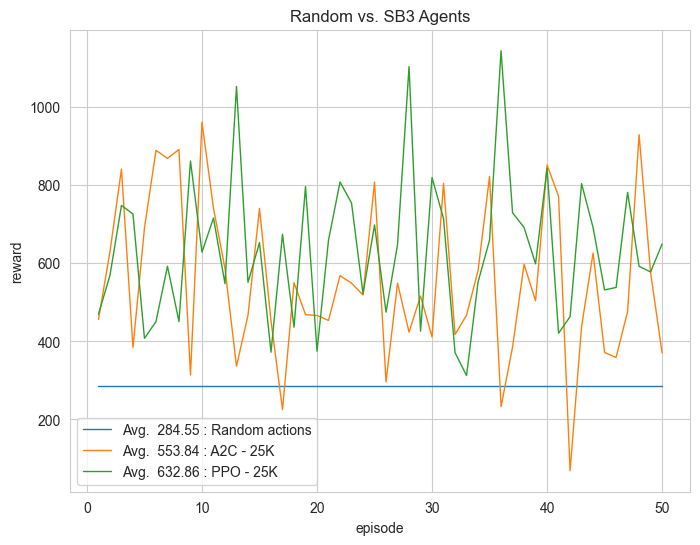

In [43]:
data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. SB3 Agents')
plt.legend()
plt.show()

In [49]:
# Train environment without calling functions (basic)
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])

model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=10000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 298      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.476   |
|    explained_variance | 0.0707   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -60.8    |
|    value_loss         | 1.67e+04 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 301       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -0.279    |
|    explained_variance | -246      |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | -0.000571 |
|    valu

info: {'total_reward': 0.0, 'total_profit': 0.794422284845212, 'position': <Positions.Long: 1>}


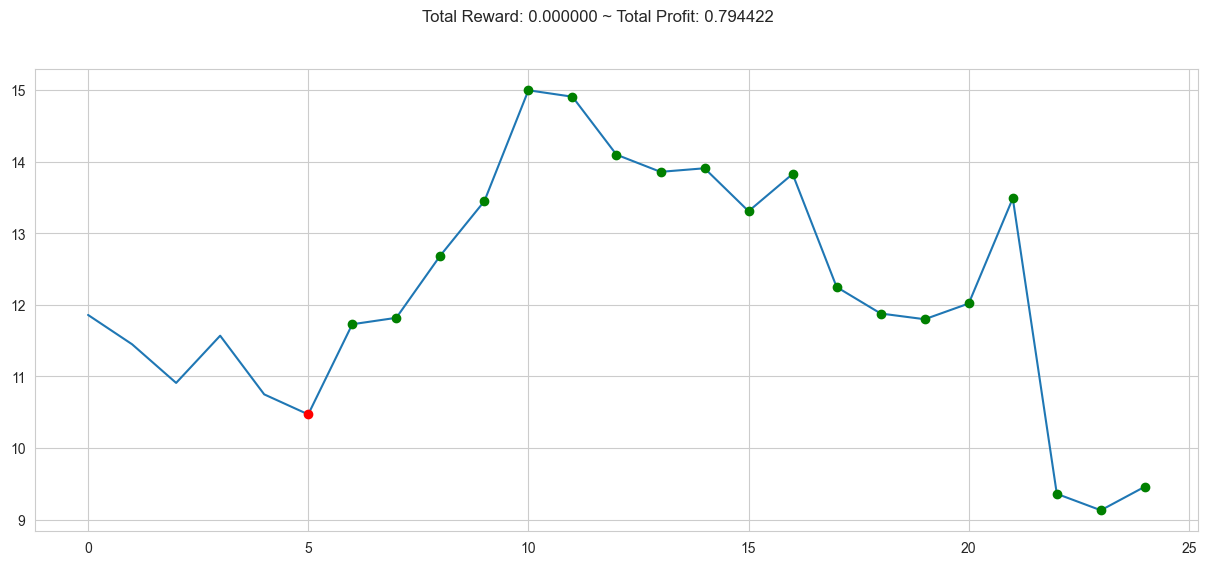

In [58]:
# Test the trained model
env = gym.make('stocks-v0', df=df, frame_bound=(90, 110), window_size=5)
observation, info = env.reset(seed=2024)

while True:
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Uncomment if the environment supports rendering
    # env.render()

    if done:
        print("info:", info)
        break

# Plot the results
plt.figure(figsize=(15, 6))
plt.cla()
env.unwrapped.render_all()  # Ensure this method is correctly defined in the environment
plt.show()